# NTSB Data Cleaning

This notebook cleans the training data in the following ways:
- Drops rows with unknown injury counts
- Drops sparse columns (> 20% missing)
- Drops columns that have been processed and are no longer needed
- Fills missing values
- Reduces categories
    - Manually combine categories for select variables
    - Remove categories with < 1% frequency
- Creates dummy variables
- Feature engineering
    - Calculate the number of people onboard and proportions of each injury category

In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [157]:
data = pd.read_csv("../data/ntsb/cleaned/master_train.csv")

In [158]:
# Drop rows with unknown event injury totals (19 rows in the train data)
data = data.loc[~data['ev_inj_tot_t'].isna()]

# Drop planes in multi-aircraft accidents with unknown injury counts
# Right now this leaves the other aircraft in the data
# Commented out line drops both aircraft from the data

acft_missing_counts_keys = data.loc[data['acft_total_person_count'].isna(), 'event_key']

for ev in acft_missing_counts_keys:
    key = ev[:-1]+'2' # suffix 2 indicates a multi-aircraft accident
    if key in data['event_key'].values:

        # Uncomment one of the following two lines
        #data = data.loc[~(data['event_key']==ev)]    # Drop aircraft with unknowable injury counts
        data = data.loc[~(data['event_key'].str.startswith(ev[:-1]))]    # Drop event with >= 1 aircraft with unknowable injury counts

### Drop columns we don't need

- The following should be run __before__ drop infrequent values, which fills in missing entries

In [159]:
## Show columns where the proportion of non-empty entries is less than 0.8

for col in data.columns:
    pna = data[col].isna().sum() / len(data)
    if pna > 0.2 :
        print(col, round(pna,3))

on_ground_collision 0.974
wind_vel_kts 0.211
inj_f_grnd 0.972
inj_m_grnd 0.974
inj_s_grnd 0.974
owner_acft 0.426
oprtng_cert 1.0
oper_cert 1.0
evacuation 1.0
rwy_len 0.474
rwy_width 0.475
acft_year 0.516
fuel_on_board 0.71


In [160]:
def drop_sparse_columns(data, threshold, safe_cols=None):
    '''
    Drops columns from data that do not contain at least a given proportion of non-empty entries
    
    Inputs
        data: pandas DataFrame
        threshold: float in [0,1], all columns with less than this proportion of non-empty entries are dropped
        safe_cols: list of names of columns that should not be dropped even if they are below the sparsity threshold
    Outputs
        data: same DataFrame with appropriate columns dropped
    '''
    # list of columns to drop if they are too sparse
    unsafe_cols = [col for col in data.columns if col not in safe_cols]

    for col in unsafe_cols:
        # calculate proportion of na entries in col
        prop_na = data[col].isna().sum() / len(data)
        
        # drop col if the column is too sparse
        if prop_na > 1 - threshold:
            data.drop(columns=col, inplace=True)
    
    return data

In [161]:
data = drop_sparse_columns(data, 0.8, safe_cols=['damage', 'acft_category', 'acft_make'])

In [162]:
# Already processed
data.drop(columns=[#'Aircraft',     # no longer in data. I'm not sure why though? I don't see where it previously was
                   'Aircraft_Key', 
                   'ev_id', 
                   #'finding_description'    # no longer in data
                   'total_seats'], inplace=True)

# (Almost) all rows have same value
data.drop(columns=['certs_held', 'unmanned'], inplace=True)

'''
Changed ntsb_table_join.ipynb so the following aren't read in

# Possible data leakage
data.drop(columns=['acft_fire', 'acft_expl'], inplace=True)
data.drop(columns=['Environmental issues', 'Organizational issues', 'Personnel issues'], inplace=True)

# Probably not relevant (ev_time seemingly boils down to light_cond)
data.drop(columns=['wx_dew_pt', 'type_fly', 'ev_time'], inplace=True)
'''

"\nChanged ntsb_table_join.ipynb so the following aren't read in\n\n# Possible data leakage\ndata.drop(columns=['acft_fire', 'acft_expl'], inplace=True)\ndata.drop(columns=['Environmental issues', 'Organizational issues', 'Personnel issues'], inplace=True)\n\n# Probably not relevant (ev_time seemingly boils down to light_cond)\ndata.drop(columns=['wx_dew_pt', 'type_fly', 'ev_time'], inplace=True)\n"

### Handling missing values

- Oddly, `gust_kts` is 100% present but `wind_vel_kts` is ~20% missing. When `wind_vel_kts` is missing, `gust_kts` is 0 more than 99% of the time, which probably means that 0 is entered by default when it's unknown

### Imputing values

Categorical
- Target variables (does it ever make sense to impute a target variable, or should we just omit from the dataset / performance metrics?)
  - `damage`: guess based on injury severity 
  - `ev_highest_injury`: calculate from injury counts
- All others: 'other/unknown'

Numerical
- `num_eng`: find max number of passengers on a 1-engine aircraft, impute 1 for aircraft with at most this many passengers, 2 for aircraft with more passengers

In [163]:
# Commenting this out so we can preserve data for when we predict injuries

## Imputing `damage` value
## Since approximately 3.9% of the entries in the damage column are missing, we choose to drop these rows.
# data = data.loc[~data['damage'].isna()]

In [164]:
## Imputing other categorical values

for col in data.columns:
    mask = data[col].isna()
    if any(mask) and data[col].dtype == 'object':
        data.loc[mask,col] = data[mask][col].replace(np.nan,'other/unknown')

In [165]:
## Imputing findings

# data[['Environmental issues', 'Organizational issues', 'Personnel issues']] = data[['Environmental issues', 'Organizational issues', 'Personnel issues']].fillna(0)

In [166]:
## Filling in missing aircraft-level injury counts

count = {
    'acft_fatal_count': 'ev_inj_tot_f',
    'acft_minor_count': 'ev_inj_tot_m',
    'acft_none_count': 'ev_inj_tot_n',
    'acft_serious_count': 'ev_inj_tot_s'
}

for missing_col, present_col in count.items():
    data.loc[data[missing_col].isna(), missing_col] = data.loc[data[missing_col].isna(), present_col]

data['acft_total_person_count'] = data[count.keys()].sum(axis=1)
data['acft_injured_person_count'] = data['acft_total_person_count'] - data['acft_none_count']

In [167]:
## There is only one examples of one-engine aircraft with more than 15 people on board, which is such an outlier
## that it's probably a typo.
## A slightly more principled way of doing this would be to fit a logistic regression

## Imputing value 1 into 'num_eng' if the total seats is less than 15, imputing 2 otherwise
data.loc[(data['num_eng'].isna())& (data['acft_total_person_count']<=15), 'num_eng'] = 1
data.loc[(data['num_eng'].isna())& (data['acft_total_person_count']>15), 'num_eng'] = 2

### Category reduction and dummy variables

#### Manual category reduction

Before we reduce infrequent values to 'other/unknown', there may be cases where we can combine categories in a more intelligent way:
- `BroadPhaseOfFlight`
- `acft_category`: group based on size?
- `far_part`: would require some research
- `light_cond`: maybe combine all conditions other than DAYL and NITE into a 'partial light' category (would have to check what all of the abbreviations mean)

In [168]:
# Reducing categories for BroadPhaseofFlight

phase_dict = {
    'Landing': 'Landing',
    'Enroute': 'Air',
    'Maneuvering': 'Air',
    'Takeoff': 'Takeoff',
    'Approach': 'Landing', # or 'Air'
    'Initial Climb': 'Takeoff',
    'Taxi': 'Ground',
    'Standing': 'Ground',
    'Emergency Descent': 'Air', # or 'Landing'
    'Uncontrolled Descent': 'Air', # or 'Landing'
    'Pushback/Tow': 'Ground',
    'Post-Impact': 'Ground',
    'Unknown': 'Unknown',
    'other/unknown': 'Unknown'
}

data['BroadPhaseofFlight'] = data['BroadPhaseofFlight'].apply(lambda x: phase_dict[x])

In [169]:
# combine varied spellings of the same aircraft make

data['acft_make'] = data['acft_make'].str.lower()

common_names = ['cessna','piper','boeing','mooney','robinson helicopter']
for name in common_names:
    data.loc[data['acft_make'].str.startswith(name),'acft_make'] = name

data.loc[data['acft_make']=='robinson','acft_make'] = 'robinson helicopter'
data.loc[data['acft_make'].str.startswith('bell helicopter'),'acft_make'] = 'bell'

#### Checking altimeter variable for validity

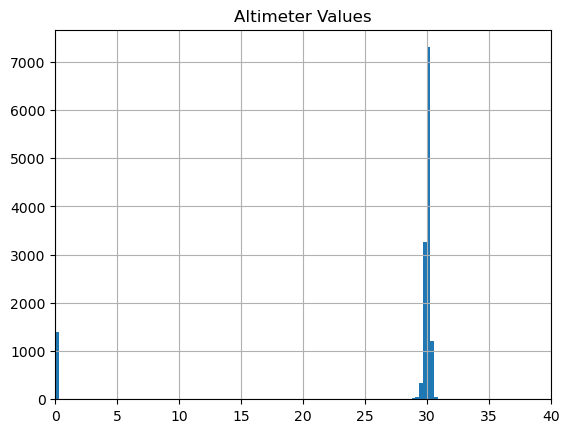

In [170]:
data['altimeter'].hist(bins=10000)
plt.xlim([0,40])
plt.title("Altimeter Values")
plt.show()

In [171]:
print(data.groupby('BroadPhaseofFlight')['altimeter'].mean())

BroadPhaseofFlight
Air        27.270658
Ground     25.273515
Landing    27.303942
Takeoff    28.319979
Unknown    21.093077
Name: altimeter, dtype: float64


In [172]:
print(data.groupby('BroadPhaseofFlight')['altimeter'].median())

BroadPhaseofFlight
Air        30.000000
Ground     29.969999
Landing    30.010000
Takeoff    30.010000
Unknown    29.920000
Name: altimeter, dtype: float64


In [173]:
print(data.groupby('BroadPhaseofFlight')['altimeter'].std())

BroadPhaseofFlight
Air         8.647392
Ground     10.949825
Landing    39.238662
Takeoff    55.980107
Unknown    13.777733
Name: altimeter, dtype: float64


##### Note:
We have very little variation in the altimeter variable, excepting some extreme outliers - otherwise, it varies around 30 and 0 for the most part.  I did some research and found that the altimeter measures altitude through measuring air pressure, but we can't really do this [without also using temperature](https://en.wikipedia.org/wiki/Barometric_formula).

##### Verdict:  I think we drop it. It doesn't tell us anything that phase of flight doesn't already tell us, really.


#### Days Since Last Inspection

In [174]:
data['insp_date'] = pd.to_datetime(data['date_last_insp'].replace('other/unknown',np.nan))
data['event_date'] = pd.to_datetime(data['ev_date'])
data['days_since_insp'] = (data['event_date'] - data['insp_date']).dt.days
data =data.drop(columns=['date_last_insp','ev_date'])

/var/folders/c8/jr_n0v1x3n52_hpzs9nlqykw0000gn/T/ipykernel_75615/1014186404.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['insp_date'] = pd.to_datetime(data['date_last_insp'].replace('other/unknown',np.nan))
/var/folders/c8/jr_n0v1x3n52_hpzs9nlqykw0000gn/T/ipykernel_75615/1014186404.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['event_date'] = pd.to_datetime(data['ev_date'])


In [175]:
data['days_since_insp'][data['days_since_insp'] < 0] = 0

/var/folders/c8/jr_n0v1x3n52_hpzs9nlqykw0000gn/T/ipykernel_75615/2998245143.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['days_since_insp'][data['days_since_insp'] < 0] = 0
/var/folders/c8/jr_n0v1x3n52_hpzs9nlqykw0000gn/T/ipykern

In [176]:
data['days_since_insp'].describe()

count    10979.000000
mean       158.787412
std        325.704908
min          0.000000
25%         30.000000
50%        100.000000
75%        226.000000
max      14084.000000
Name: days_since_insp, dtype: float64

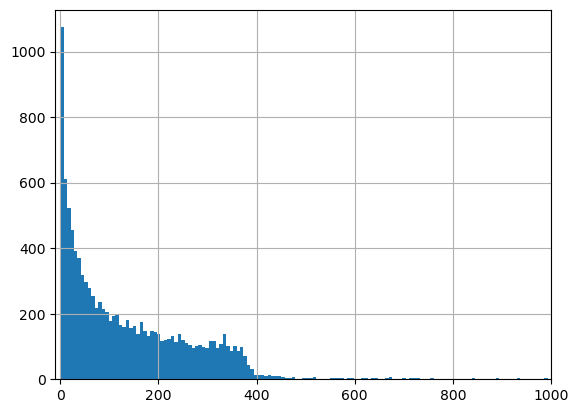

In [177]:
data['days_since_insp'].hist(bins=2000)
plt.xlim(-10,1000)
plt.show()

#### Injury Proportions & Removing Total Seats

In [178]:
data['acft_total_person_count'][data['acft_total_person_count'] == 0] = 1 # Where zero, set to 1

/var/folders/c8/jr_n0v1x3n52_hpzs9nlqykw0000gn/T/ipykernel_75615/1164814864.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['acft_total_person_count'][data['acft_total_person_count'] == 0] = 1 # Where zero, set to 1
/var/folders/c8/

#### Automated category reduction

We'll reduce categories by reassigning all categories with frequency $< \alpha$ to 'other/unknown' (for some $\alpha \in [0.01, 0.05]$)

Note: when we go to build the model, we'll have to make sure we're reducing categories based on their frequency in the training set and NOT based on their frequency in the test set

In [179]:
def reduce_categories_fill_na(data, columns, threshold):
    '''
    For each of the specified columns, find the values that occur with frequency lower than the threshold,
    and replace these values and missing values by 'other/unknown'.
    This is only intended for categorical variables
    
    Inputs
        data: pandas DataFrame
        columns: list of column names to simplify
        threshold: float in [0,1], frequency threshold for removing 
    Outputs
        data: pandas DataFrame
    '''

    freq_thresh = threshold * len(data)

    for col in columns:
        counts = data[col].value_counts()
        
        for i in counts.index:
            if counts[i] < freq_thresh:
                data.loc[data[col]==i, col] = 'other/unknown'
        
        data.loc[data[col].isna(), col] = 'other/unknown'

    return data

In [180]:
categorical_features = ['light_cond', 'BroadPhaseofFlight', 'eng_type', 'far_part', 'acft_make', 'acft_category',
                    'homebuilt', 'fixed_retractable', 'second_pilot']
# Note: intentionally omitted 'ntsb_no', 'ev_highest_injury', 'Aircraft_ID', 'event_key', 
#                               'damage', 'acft_model'

data = reduce_categories_fill_na(data, categorical_features, 0.01)

In [181]:
data = pd.get_dummies(data, columns=categorical_features)

### Target engineering

In [182]:
# Calculate the proportion in each injury level
data['acft_prop_inj_n'] =  data['acft_none_count'] / data['acft_total_person_count']
data['acft_prop_inj_m'] =  data['acft_minor_count'] / data['acft_total_person_count']
data['acft_prop_inj_s'] =  data['acft_serious_count'] / data['acft_total_person_count']
data['acft_prop_inj_f'] =  data['acft_fatal_count'] / data['acft_total_person_count']

### Save cleaned data

In [183]:
data.to_csv('../data/ntsb/cleaned/ntsb_train_cleaned.csv', index=False)